# Pipeline
This small notebook serves to describe the usage and implementation of the python scripts used by the pipeline. Each section shows the flow of each script's main function, in a way to illustrate how they work.

In [ ]:
RES_DIR="../proj/simulations/results/"
CONFIG_NAME="NonFrequentUpdates-#0"

These will be the results that will be used for this demonstration.

## Importing Data from Omnet
The process of importing results from their `sca` and `vec` formats (straight from a simulation run) is done in the parseData script

First, the script converts data to their csv format using `scavetool` and opens the csvs as dataframes.

In [ ]:
from parseData import convertToCsv, filterMetrics, filterNans, openDatasets, saveCsv, convertValsToList
convertToCsv(RES_DIR, CONFIG_NAME)

sca, vec = openDatasets(CONFIG_NAME) # This opens the files and parses some values into a workable format
# Remove entries that don't have data
sca, vec = filterNans(sca, vec)
sca, vec = convertValsToList(sca, vec)

### Metrics
Then, the scripts filters all data to select only the attributes that we deem relevant and want to analyze later.
Bellow are the metrics we chose to filter:
+ link layer throughput => eth mac txPk
+ application layer throughput - => Load in routers (incomingDataRate)
+ end to end delay? => Useful?
+ request-response/communication latency
+ link utilization => Use throughput and channel capacity TODO
+ number of train updates that the server has received by simulation time=> Vector
+ Number of train updates sent as a response to each client request => Histogram + vector
+ Number of train updates that were discarded per request as a result of being expired => Vector + hist

We save this data to override the original csvs

In [ ]:
import pandas as pd
# The values bellow are replicated to parseData, to change the scripts go there instead.
# Vectors - parse vec dataset
linkLayerThroughput = lambda x: (x["name"] == "txPk:vector(packetBytes)") & (("type" not in x) or (x["type"] == "vector"))
appLayerThroughput = lambda x: (x["name"].str.contains("DataRate")) & (("type" not in x) or (x["type"] == "vector")) #  (x["module"].str.contains("Router")) => Use this to filter only router
clientResponseDelay = lambda x: x["name"] == "timeToResponse"
serverSentTrainUpdates = lambda x: (x["name"] == "serverSentTrainUpdates")
serverDroppedTrainUpdates = lambda x: (x["name"] == "serverDroppedTrainUpdates")
serverReceivedTrainUpdates = lambda x: (x["name"] == "serverReceivedTrainUpdates")
vec_metrics = (linkLayerThroughput, appLayerThroughput, clientResponseDelay, serverSentTrainUpdates, serverDroppedTrainUpdates, serverReceivedTrainUpdates)

# Histograms - parse sca dataset
clientEndToEndDelay = lambda x: (x["name"] == "endToEndDelay:histogram")  & (x["module"].str.contains("client")) & (("type" not in x) or (x["type"] == "histogram"))
#sca_metrics = (clientEndToEndDelay, trainEndToEndDelay)
sca_metrics = [clientEndToEndDelay]

# vec[linkLayerThroughput]
#counts = sca["name"].value_counts()
#counts.to_csv('name.csv',index=True)

# Filter metrics only selects the values above
sca, vec = filterMetrics(sca, vec)
vec


## Evaluate Results
The parseData script also uses the data produced in the previous step to generate statistics and results to be analyzed later using plots or tables.
The statistics that were deemed relevant are as follows:
+ link layer throughput and application layer throughput
  + clients => **calculate overall std, min, max**
  + server apps => **evolution of throughput**
+ end to end delay/request-response/communication latency => **clients histogram, max, mean, 99 percentile** - Quality of experience
+ link utilization => **Percentage Router to Server** => See if it's proportional to no of trains
+ number of train updates that the server has received by simulation time
+ Number of train updates sent as a response to each client request
+ Number of train updates that were discarded per request as a result of being expired => Relationship with delay, **Standard deviation, Max**j

The script simply adds new std, max, min, avg and mean columns to the existing dataset.

In [ ]:
def addStatistics(df, colname):
    import numpy as np
    df[colname + "_std"] = df[colname].apply(lambda x: np.std(x))
    df[colname + "_max"] = df[colname].apply(lambda x: np.max(x))
    df[colname + "_min"] = df[colname].apply(lambda x: np.min(x))
    df[colname + "_mean"] = df[colname].apply(lambda x: np.mean(x))
    df[colname + "_avg"] = df[colname].apply(lambda x: np.average(x))

addStatistics(vec, "vecvalue")
#addStd(sca, "vecvalue")
vec


In [ ]:
saveCsv(sca, vec, CONFIG_NAME)

## Plotting Results
The generatePlots script uses the statistics generated by the previous script to generate plots to visualize results. The following plots are generated in this step as they were deemed most relevant:

+ link layer throughput and application layer throughput
  + clients => plot along time => Load coming from clients
  + server apps =>  plot along time => Load on server
+ end to end delay/request-response/communication latency => **clients histogram, max, mean, 99 percentile** - Quality of experience
+ link utilization => TODO **Percentage Router to Server** plot along time => See if it's proportional to no of trains
+ number of train updates that the server has received by simulation time => std, mean, avg
+ Number of train updates sent as a response to each client request => std, mean, avg
+ Number of train updates that were discarded per request as a result of being expired => Relationship with delay, **Standard deviation, Max** => std, mean, avg

Some functions to parse modules - for later use

In [36]:
filterByClients = lambda x: x["module"].str.contains("client\[")
filterByClientRouter = lambda x: x["module"].str.contains("clientR")
filterByTrains = lambda x: x["module"].str.contains("train\[")
filterByTrainRouter = lambda x: x["module"].str.contains("trainR")
filterByIncomingTraffic = lambda x: x["name"].str.contains("incoming")
filterByOutgoingTraffic = lambda x: x["name"].str.contains("outgoing")

In [35]:
vec[(appLayerThroughput(vec)) & (filterByClients(vec))]

,run,module,name,vectime,vecvalue,vecvalue_std,vecvalue_max,vecvalue_min,vecvalue_mean,vecvalue_avg
667,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[0].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2001.370637,28320.0,0.0,367.208968,367.208968
685,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[0].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2001.370637,28320.0,0.0,367.208968,367.208968
1095,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[1].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1939.290375,22640.0,0.0,348.886462,348.886462
1113,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[1].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1939.290375,22640.0,0.0,348.886462,348.886462
1350,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[2].eth[0].queue,incomingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1970.001153,22640.0,0.0,355.909169,355.909169
1368,NonFrequentUpdates-0-20221208-21:22:50-7525,MuenchenNetwork.client[2].eth[0].queue,outgoingDataRate:vector,"[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1970.001153,22640.0,0.0,355.909169,355.909169


Define function to plot metrics according to simulation time. Bins are created on the data so that the graph is more perceptible.

HERE


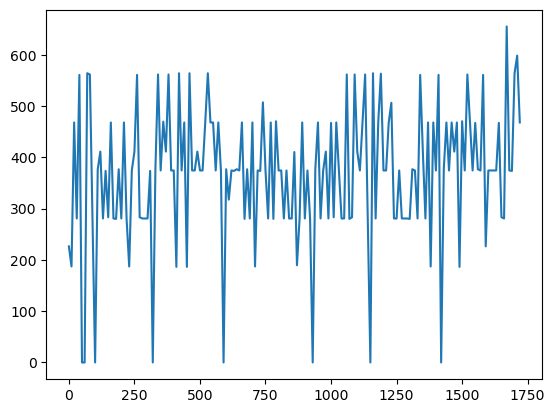

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plotLine(x, y, N):
    def binData(x, y, N):
        n_y = np.average(y[:len(y) - len(y) % N].reshape(-1, N), axis=1)
        n_x = x[:len(x) - len(x) % N:N]
        if (len(y) % N) != 0:
            np.append(n_y, np.average(y[len(y) - len(y) % N:-1]))
            np.append(n_x, x[:-1])
        return n_x, n_y
    if not (isinstance(x, list) and all(isinstance(el, np.ndarray) for el in x)):
        print("HERE")
        o_x = np.array(x)
        x = list()
        x.append(o_x)
    if not (isinstance(y, list) and all(isinstance(el, np.ndarray) for el in y)):
        o_y = np.array(y)
        y = list()
        y.append(o_y)


    fig, ax = plt.subplots()
    for data_x, data_y in zip(x, y):
        n_x, n_y = binData(data_x, data_y, N)
        sns.lineplot(x=n_x, y=n_y, ax=ax)


client = vec[(appLayerThroughput(vec)) & (filterByClients(vec))].iloc[0]
plotLine(client.vectime, client.vecvalue, 100)

Throughput of incoming traffic to client nodes:

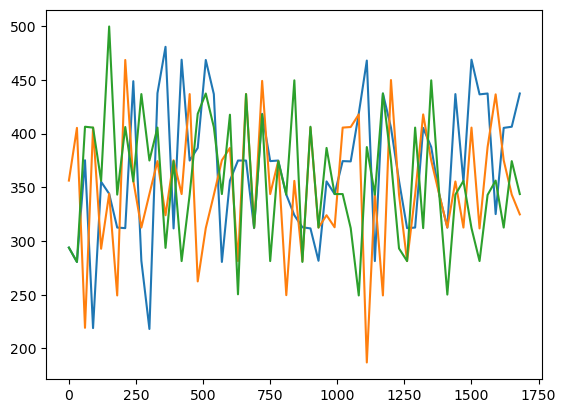

In [49]:
appLayerIncomingThroughput_Clients = vec[(appLayerThroughput(vec)) & (filterByClients(vec)) & (filterByIncomingTraffic(vec))]
x = [np.array(i.vectime) for _, i in appLayerIncomingThroughput_Clients.iterrows()]
y = [np.array(i.vecvalue) for _, i in appLayerIncomingThroughput_Clients.iterrows()]
plotLine(x, y, 300)

Save results to csv